In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.sparse import hstack
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud,STOPWORDS
import time
import seaborn as sns

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bigdata-01QYD/s259444/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/bigdata-01QYD/s259444/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bigdata-01QYD/s259444/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
column_names=["country", "description", "designation", "province", "region_1", "region_2", "variety", "winery", "quality"]
wine_df = pd.read_csv('dev.tsv', sep='\t', header=1, names = column_names)
wine_df.head()

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
1,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
2,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
3,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0
4,New Zealand,Classic gooseberry and pink grapefruit notes f...,NaN,Marlborough,NaN,NaN,Sauvignon Blanc,Cloudy Bay,48.0


In [4]:
wine_df.shape

(120743, 9)

The dataset has 120743 rows and 9 columns. For the columns we have the country from where the vine has been produced, the province and the two regions. So the province inlcudes the regions, and the country includes the province.

Then there is the designation that is the name give to the wine by the produce, the variety describes the  type of grapes that are used, then the winery from which is produced.

Then there's the description provided by the reviewer, and also the quality scores.

All the attributes are categorical and nominal, exeception made for the quality one, that is numerical and ordinal too.

In [5]:
wine_df.describe()

,quality
count,120743.000000
mean,46.277863
std,11.924830
min,0.000000
25%,38.000000
50%,46.000000
75%,55.000000
max,100.000000


from the table above, we can see the mean and the standard deviation, and also understand partially its distribution thanks to the percentiles.

In [6]:
wine_df.isnull().values.any()

True

In [7]:
wine_df.isnull().sum()

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72007
variety            0
winery             0
quality            0
dtype: int64

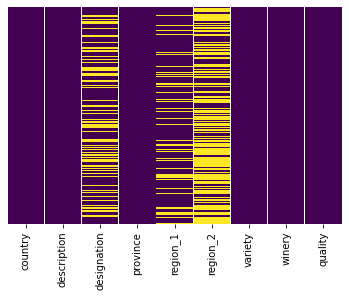

In [8]:
ax = sns.heatmap(wine_df.isnull(), yticklabels=False,cbar=False,cmap='viridis')
ax.figure.savefig('null_heatmap.png')

The table and plot show that region_2 has more than the half of null values, region_1 20000 records and designation 30000. There also some records (5) that have also the country value null. So as first solution, designation, region_1 and region_2 columns are dropped, and also the 5 rows with country value null.

In [4]:
wine_df = wine_df.dropna(how="any", subset=["winery", "country", "variety", "province"])
wine_df = wine_df.drop(["designation", "region_1", "region_2"], axis=1)

In [10]:
wine_df.shape

(120738, 6)

Let's now do a brief cardinality analysis of the attributes of the dataset.

In [11]:
for column in wine_df.columns:
    uniq = np.unique(wine_df[column])
    print('{}: {} distinct values\n'.format(column,len(uniq)))

country: 48 distinct values

description: 85001 distinct values

province: 444 distinct values

variety: 603 distinct values

winery: 14104 distinct values

quality: 86 distinct values



It's kind of funny to notice that only half of the descriptions are unique.

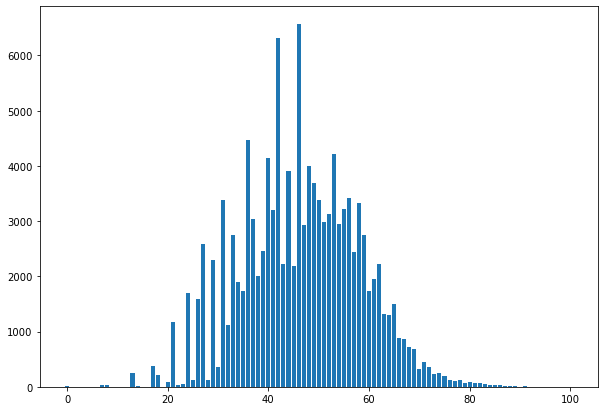

In [12]:
votes = wine_df.groupby(['quality']).size()
indexes = votes.index
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(indexes, votes)
plt.show()
fig.savefig('score_distribution.png')

This is the distribution of the quality score. It's very close to a normal one, with 46,27 as mean.

Now just out of curiosity, let's investigate on how many zeros there are in the quality scores. Because if someone gives 0 in a range of 100 to the scores, the wine must not be wine but winegar. So we can consider them like kinda of outlier

In [13]:
print("There are {} evaluations were the score assigned is 0" .format(votes.iloc[0]) )

There are 15 evaluations were the score assigned is 0


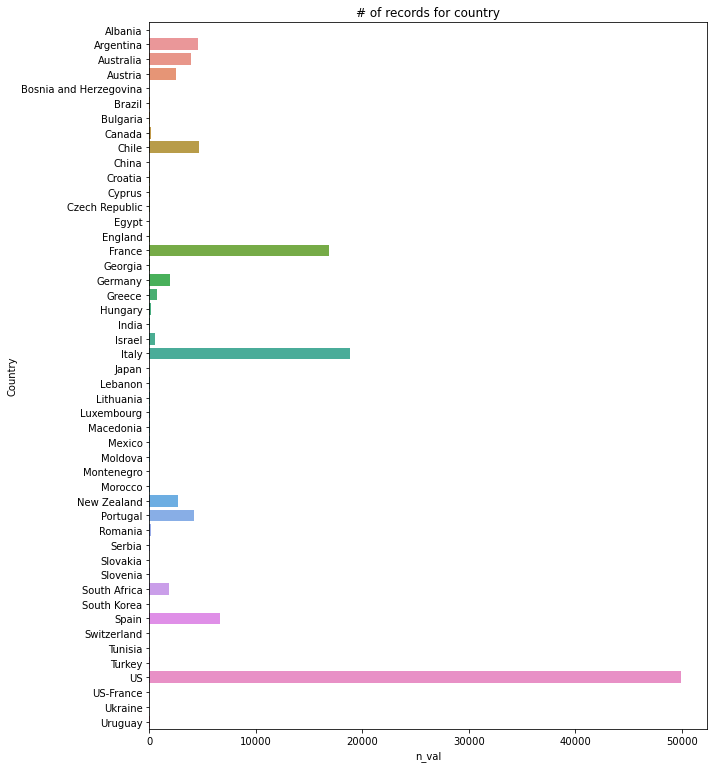

In [19]:
val_for_country = wine_df.groupby('country').size()
plt.figure(figsize=(10,13))
ax = sns.barplot(x=val_for_country, y=val_for_country.index)
plt.title('# of records for country')
plt.xlabel('n_val')
plt.ylabel('Country')
ax.figure.savefig('records_for_country.png')

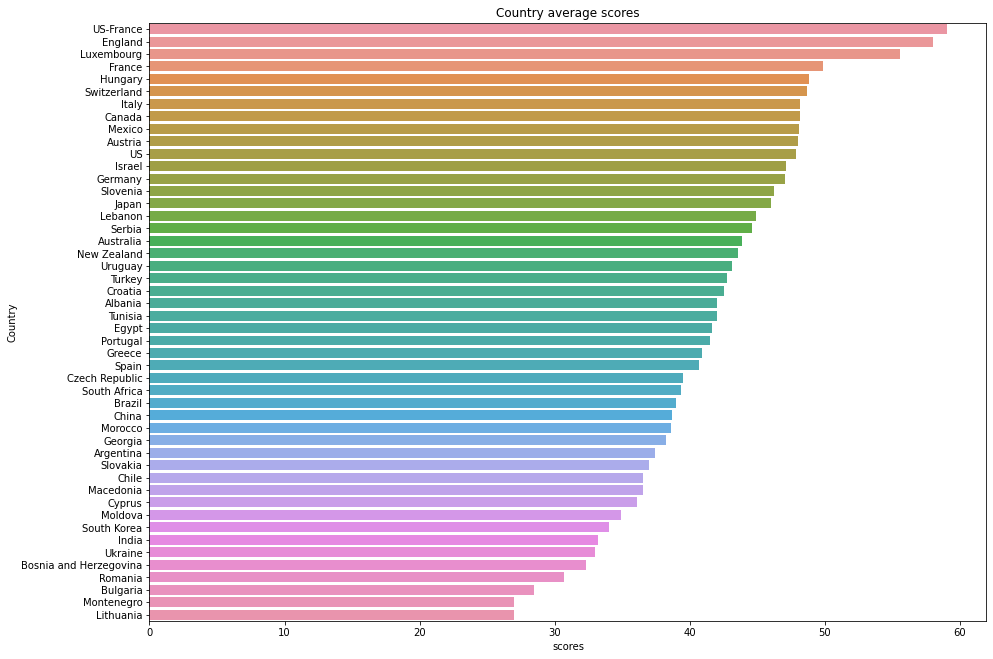

In [23]:
country_avg = wine_df.groupby('country').mean()['quality'].sort_values(ascending=False).to_frame()
plt.figure(figsize=(15,11))
ax = sns.barplot(x=country_avg['quality'], y=country_avg.index)
plt.title('Country average scores')
plt.xlabel('scores')
plt.ylabel('Country')
ax.figure.savefig('country_average_scores.png')

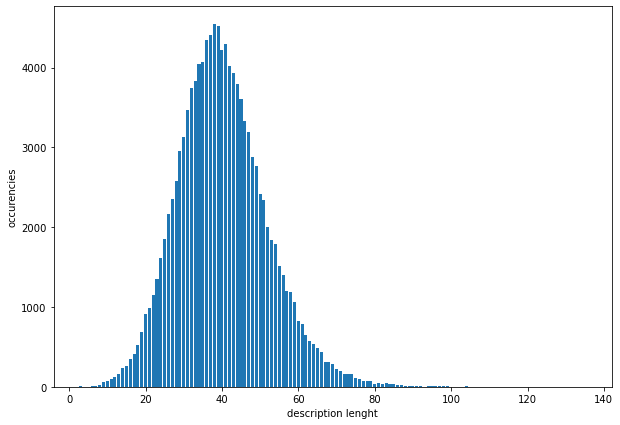

<Figure size 432x288 with 0 Axes>

In [16]:
wine_df['descrlen'] = wine_df['description'].apply(lambda descr:len(descr.split()))
len_series = wine_df.groupby('descrlen').size()
fig, ax = plt.subplots (figsize = (10,7))
ax.bar(len_series.index, len_series)
ax.set_xlabel('description lenght')
ax.set_ylabel('occurencies')
plt.show()
plt.savefig('descrlen_distribution.png')

The plot shows the distribution of the description lenghts, to be interpreted as number of words for description. This one too is a normal distribution, with averagea around 40.

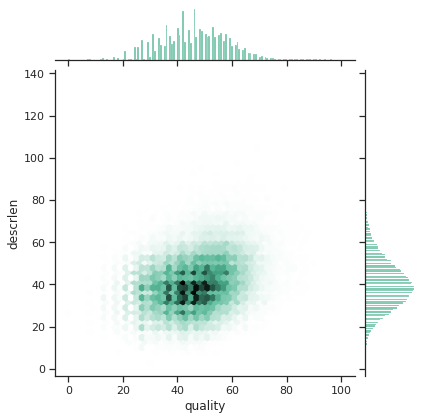

In [17]:
sns.set_theme(style='ticks')
ax = sns.jointplot(x=wine_df['quality'], y=wine_df['descrlen'], kind='hex', color="#4CB391")
ax.fig.savefig('descrlen-quality_jointplot.png')

Now, let's divide the scores in 5 equal ascending categories. For computing the division we use percentiles. So we have five percentiles and for the grades: Average one, then discending loe grade rated, and bad rated, while ascending from the average grade, we have descrete and great rated. So let's plot the word clouds just to make and idea of what the descriptions tell for the different gradeds.

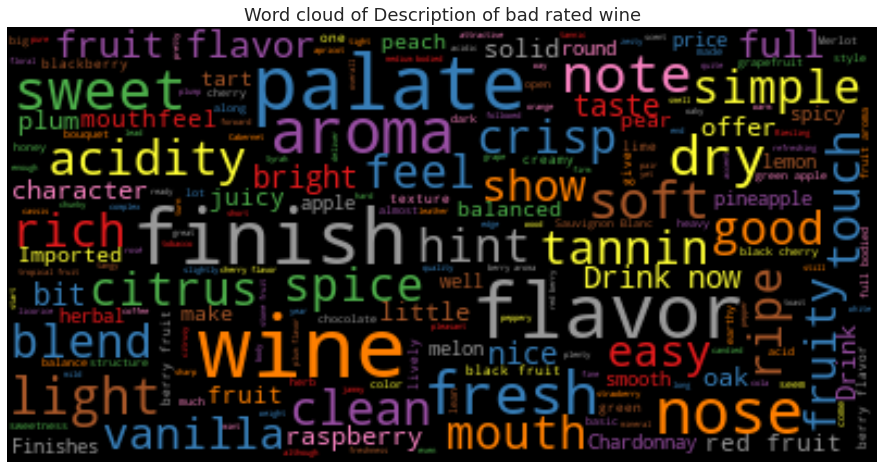

<Figure size 432x288 with 0 Axes>

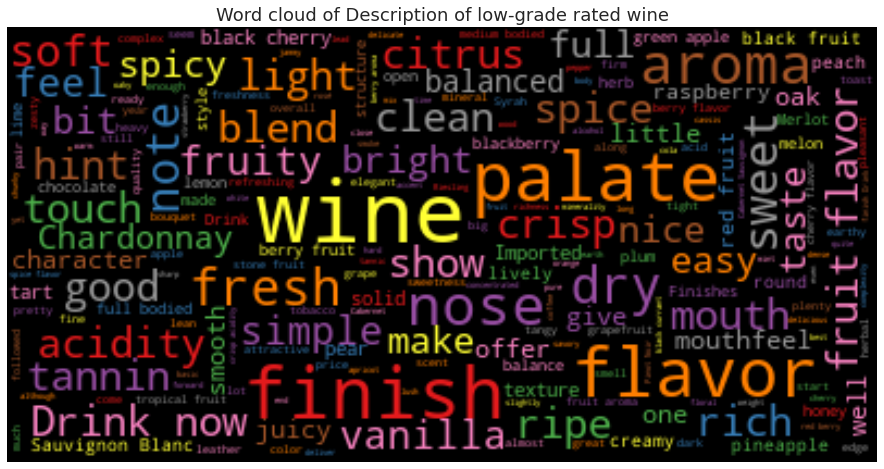

<Figure size 432x288 with 0 Axes>

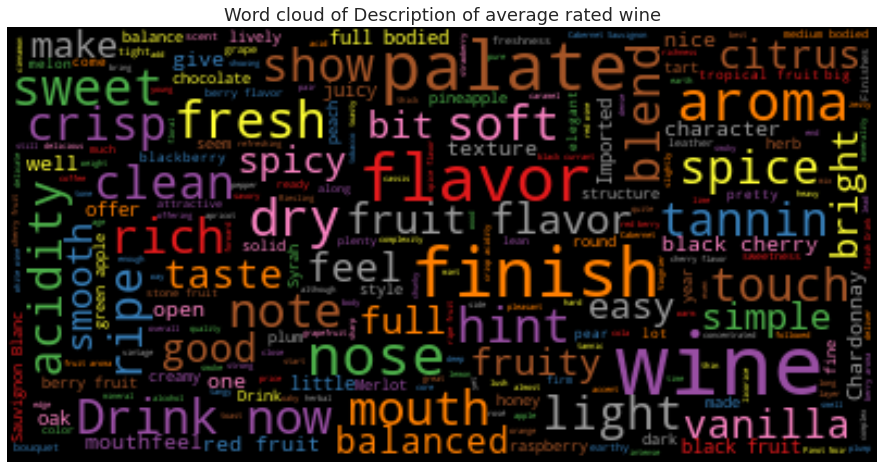

<Figure size 432x288 with 0 Axes>

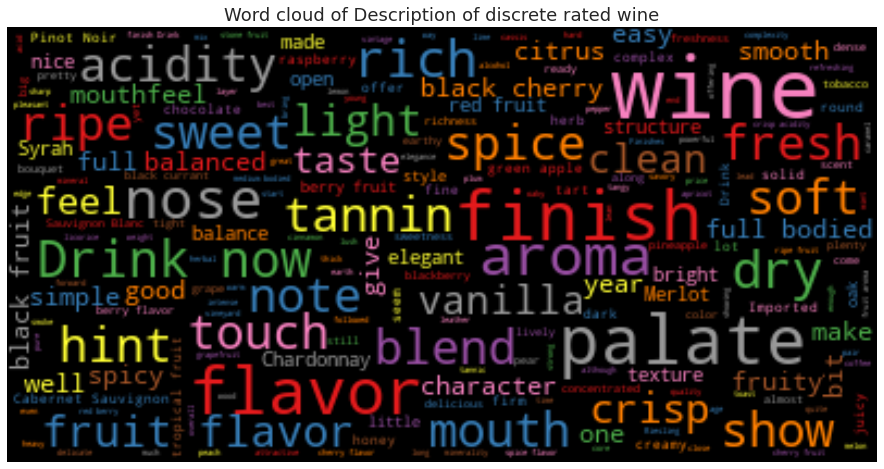

<Figure size 432x288 with 0 Axes>

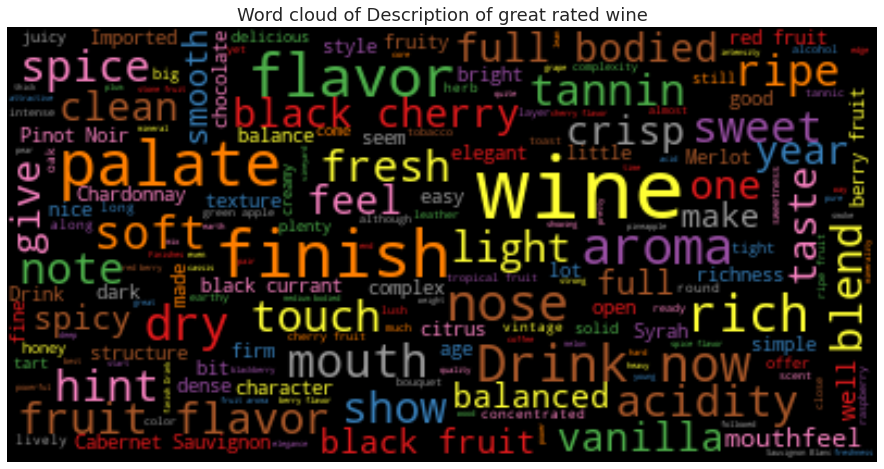

<Figure size 432x288 with 0 Axes>

In [18]:
ix = [p for p in range(20,120,20)]
perc = [np.percentile(wine_df['quality'], p) for p in range(20,120,20)]
categories=['bad', 'low-grade', 'average', 'discrete', 'great']
sns.set_context("talk")
for i,p in enumerate(perc):
  print("")
  plt.figure(figsize= (16,8))
  stringa = "WC_" + categories[i] + "_rated.png"
  stringa= str(stringa)
  plt.title('Word cloud of Description of {} rated wine' .format(categories[i]))
  wc = WordCloud(max_words=1000,max_font_size=40,background_color='black', stopwords = STOPWORDS,colormap='Set1')
  wc.generate(' '.join(wine_df[wine_df['quality']<p]['description']))
  plt.imshow(wc,interpolation="bilinear")
  plt.axis('off')
  plt.show()
  plt.savefig(stringa)

In [5]:
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def tolemmas(text):
    tokens = word_tokenize(text)
    lemma_function = WordNetLemmatizer()
    lemmas = ""
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
        #if not lemma in stop_words:
        lemmas = lemmas + lemma + " "
    return lemmas

In [6]:
wine_df['description'] = wine_df['description'].replace('[^a-zA-Z0-9]', ' ', regex = True)
wine_df['description'] = wine_df['description'].str.lower()
wine_df['description'] = wine_df['description'].map(lambda sentence:tolemmas(sentence))

In the two cells above starts the preprocessing of the description attribute. The categorical attributes cannot be given to the machine learning model as they are. Because those models only works with numbers. So first thing first, punctuaction marks are removed, then all the text is converted to lower letters. The next important step is to lemmatize words. From wikipedia, lemmatisation  is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. This is why, in the function defined above, nouns, verbs, adverbs and pronoun are mapped. So some examples can be was->be mice->mouse ->meeting->meet. This is different from stemming that is the process of reducing inflected  words to their word stem, base or root form—generally a written word form.

After doing this, each description, that is a vector of words, is encoded with Tfidf. Deeply analyzed during the course, Tfidf  is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. One important thing to be aware is that the model with this encoding does not learn the "meaning"  of the words, for that there are other types of encoding and models.

After doing different simulations, I decided to not remove stop words, because they can bring additional value to the model, in fact the r2 score is higher with stopword than without. This I think is more valid also for a different model, that I will not explore in this notebook, because was only mentioned in theory lessons of the course, but not deeply analyzed.

In [7]:
vect_tfidf = TfidfVectorizer(min_df=5)
descrtfidf = vect_tfidf.fit_transform(wine_df['description']).toarray()

vect_1hot = DictVectorizer(sparse=False, dtype=int)
wine_df_tohot = wine_df.filter(['country', 'province', 'variety', 'winery'], axis=1)
data = wine_df_tohot.to_dict('records')
cat_1hot = vect_1hot.fit_transform(data)

X_dev = np.concatenate([descrtfidf, cat_1hot], axis=1)
y_dev = wine_df['quality']
X_dev, y_dev = shuffle(X_dev, y_dev, random_state=0)

For the other categorical attributes, one-hot encoding is used.

For the developement dataset in both tfidf and one-hot encoding fit_transform is used, so this means that the distribution of the data is fitted and then the same data is transformed to the encoding

In the cell above, the evaluation dataset is loaded, and the same preprocessing steps are made. Here no rows are dropped, cause these missing lines would obviously cause issues with the submission.
The difference with the developement set is that here for both tfidf and one-hot encoding we use first the fit method and then the transform one. This because the dev set is way more larger than the evaluation one, so "reality" can be better rappresented.

In [8]:
column_names_ev=["country", "description", "designation", "province", "region_1", "region_2", "variety", "winery"]
wine_df_ev = pd.read_csv('eval.tsv', sep='\t', header=0, names = column_names_ev)
wine_df_ev = wine_df_ev.drop(["designation", "region_1", "region_2"], axis=1)

wine_df_ev['description'] = wine_df_ev['description'].replace('[^a-zA-Z0-9]', ' ', regex = True)
wine_df_ev['description'] = wine_df_ev['description'].str.lower()
wine_df_ev['description'] = wine_df_ev['description'].map(lambda sentence:tolemmas(sentence))

vect_tfidf = TfidfVectorizer(min_df=5)
vect_tfidf.fit(wine_df['description'])
descr_ev_tfidf = vect_tfidf.transform(wine_df_ev['description']).toarray()

wine_df_ev_tohot = wine_df_ev.filter(['country', 'province', 'variety', 'winery'], axis=1)
data_ev = wine_df_ev_tohot.to_dict('records')
vect_1hot = DictVectorizer(sparse=False, dtype=int)
vect_1hot.fit(data)
cat_1hot_ev = vect_1hot.transform(data_ev)

X_ev = np.concatenate([descr_ev_tfidf, cat_1hot_ev], axis=1)

In [23]:
ridge_params = {'alpha': [0.1, 0.2, 0.7]}

In [24]:
clf = Ridge(alpha=0.1)
scores = cross_val_score(clf, X_dev, y_dev, cv=4)
print(scores)

[0.7107029  0.71915213 0.71570793 0.71326291]


In [25]:
clf = Ridge(alpha=0.2)
scores = cross_val_score(clf, X_dev, y_dev, cv=4)
print(scores)

[0.71754641 0.72590613 0.72302613 0.72092031]


Since the r2 scores of the cross validation has no large variance, and since the RAM resources of the account at Jupyter Polito are limited, the other hyperparameter setting of alpha will be explored without cross validation. Also because for now, no PCA for dimensionality reduction is applied.

In [10]:
seed=1234
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2, random_state=seed)

In [26]:
clf = Ridge(alpha=0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_true = y_val
r2 = r2_score(y_true, y_pred)
print("r2 score for alpha=0.5: {}".format(r2))

r2 score for alpha=0.5: 0.7339390879492909


In [27]:
clf = Ridge(alpha=0.7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_true = y_val
r2 = r2_score(y_true, y_pred)
print("r2 score for alpha=0.7: {}".format(r2))

r2 score for alpha=0.7: 0.7344847198556729


In [28]:
clf = Ridge(alpha=0.5)
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_ev)

pred_df = pd.DataFrame()
pred_df['Id'] = wine_df_ev.index
pred_df['Predicted'] = y_pred

pred_df.to_csv('Final_sub_ridge_0.5.csv', header=True, index=None)

After trying to predict the score with lasso model, it's time to change to **MLPRegressor** used also in lab8. This is a module supplied by scikit learn. It's based on neural network. So with respect to the previous model we lose the "interpretability" of the model but we gain in performance. In fact it's known that NN are kinda of the best in perfomances. What scikit learn does, is to provide like a wrapper to construct the multi layer perceprton regressor, with just a line of code, and this is an advantage. The disadvantage is that with scikit learn is no possible to use GPUs. In fact GPUs perform way better than CPUs for this kind of matrix computations. Good news is that my account on Jupyter.polito is not enabled to use GPUs, so nothing would be changed. Otherwise, the solution would have been implementing the MLPRegressor from scratch with Pytorch, or there are also some libraries that wraps Pytorch with scikit-learn. Combining the advantages of the two.

For this reason no cross validation was applied for this model. But, different setting of some of the hyperparameters were explored in a differnt notebook, for avoiding a kernel restart.

I have decided to add **two hidden layers**. For the activation function the **rectified linear unit** has been choosen. This function is defined like:
$$
R(x)
= 
\begin{cases}
x \text{ if }  x > 0\\
0 \text{ if } x<= 0 \
\end{cases}
$$

The biggest advantage of Relu function is that there is no saturation of the gradients. This speed up a lot the stochastic gradient discent, with respect to the tanh and sigmoid fucntions

**Learning rate**: It is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope. Using a low learning rate might be a good idea, in terms of making sure we do not miss any local minimum, but it can also mean that it will take a lot of time to converge, expecially working with CPUs and not GPUs, especially if we get a stuck in sort of plateau region. There is a lot of research in this field how to initialize the weights and how to adjust the learning rate, also because sometimes is difficult to know how big is the "wall" that gets the model stuck in a local minima.

*(form B.Caputo Machine Learning and Deep Learning 2020)*.

In this project the **lr** is set to the default value 0.001. Other values has been tried (e.g. 0.01) with the adaptive mode (i.e. the lr is divided by 2 if the loss does not improve for the epochs in n_iter_no_change), the classifier gets stuck in a sort of local minimum, so it finds a sub optimal solution, and the perfomances are worst than setting the intial lr to 0.001 and not adaptive.

**Number of epochs** i.e. max_iteration is set to 180, because after that there no significant improvement on the loss.


In [27]:
clf = MLPRegressor(hidden_layer_sizes=(128,64), activation='relu', verbose=True, solver='sgd', max_iter=180, tol=0.01, n_iter_no_change=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_true = y_val
r2 = r2_score(y_true, y_pred)
print("r2 score for MLPregressor: {}".format(r2))

Iteration 1, loss = 58.47685619
Iteration 2, loss = 25.16348556
Iteration 3, loss = 21.35660277
Iteration 4, loss = 19.19306005
Iteration 5, loss = 17.24127753
Iteration 6, loss = 15.58359859
Iteration 7, loss = 14.91037985
Iteration 8, loss = 13.53853254
Iteration 9, loss = 12.93454563
Iteration 10, loss = 12.24097862
Iteration 11, loss = 11.43025652
Iteration 12, loss = 10.72454331
Iteration 13, loss = 10.23076475
Iteration 14, loss = 9.63218890
Iteration 15, loss = 9.31063889
Iteration 16, loss = 8.60000682
Iteration 17, loss = 8.32127603
Iteration 18, loss = 7.69016729
Iteration 19, loss = 7.31025141
Iteration 20, loss = 6.92619066
Iteration 21, loss = 6.46324693
Iteration 22, loss = 6.36946246
Iteration 23, loss = 5.74046626
Iteration 24, loss = 5.46369452
Iteration 25, loss = 5.32415754
Iteration 26, loss = 4.85906767
Iteration 27, loss = 4.73114508
Iteration 28, loss = 4.20550025
Iteration 29, loss = 4.17765840
Iteration 30, loss = 3.67226107
Iteration 31, loss = 3.56727229
Iter

In [31]:
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_ev)

pred_df = pd.DataFrame()
pred_df['Id'] = wine_df_ev.index
pred_df['Predicted'] = y_pred

pred_df.to_csv('Final_MLP_128_64_it180_25.csv', header=True, index=None)

Iteration 1, loss = 53.36497278
Iteration 2, loss = 23.74714711
Iteration 3, loss = 20.20465267
Iteration 4, loss = 17.84762389
Iteration 5, loss = 16.19518446
Iteration 6, loss = 15.01944114
Iteration 7, loss = 13.80788894
Iteration 8, loss = 12.87584372
Iteration 9, loss = 12.01514529
Iteration 10, loss = 11.28817093
Iteration 11, loss = 10.55714273
Iteration 12, loss = 10.05196476
Iteration 13, loss = 9.38316831
Iteration 14, loss = 8.80913995
Iteration 15, loss = 8.25002876
Iteration 16, loss = 7.75291178
Iteration 17, loss = 7.23323827
Iteration 18, loss = 6.82079867
Iteration 19, loss = 6.31649001
Iteration 20, loss = 6.17899620
Iteration 21, loss = 5.64048992
Iteration 22, loss = 5.33056768
Iteration 23, loss = 5.12040676
Iteration 24, loss = 4.80308721
Iteration 25, loss = 4.60262889
Iteration 26, loss = 4.12656612
Iteration 27, loss = 3.95758679
Iteration 28, loss = 3.66749813
Iteration 29, loss = 3.39255872
Iteration 30, loss = 3.19532563
Iteration 31, loss = 2.97677860
Itera

In [33]:
clf = MLPRegressor(hidden_layer_sizes=(256,128), activation='relu', verbose=True, solver='sgd', max_iter=180, tol=0.01, n_iter_no_change=35)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_true = y_val
r2 = r2_score(y_true, y_pred)
print("r2 score for MLPregressor: {}".format(r2))

Iteration 1, loss = 58.39732895
Iteration 2, loss = 24.95301632
Iteration 3, loss = 21.08542204
Iteration 4, loss = 18.62028709
Iteration 5, loss = 16.87199302
Iteration 6, loss = 15.41080970
Iteration 7, loss = 14.04697074
Iteration 8, loss = 13.02643491
Iteration 9, loss = 12.32034061
Iteration 10, loss = 11.15985326
Iteration 11, loss = 10.49603342
Iteration 12, loss = 9.69375657
Iteration 13, loss = 8.95657711
Iteration 14, loss = 8.44922600
Iteration 15, loss = 7.81752241
Iteration 16, loss = 7.22114990
Iteration 17, loss = 6.60146457
Iteration 18, loss = 6.10174544
Iteration 19, loss = 5.91290717
Iteration 20, loss = 5.45381228
Iteration 21, loss = 4.66781691
Iteration 22, loss = 4.66500247
Iteration 23, loss = 4.09492473
Iteration 24, loss = 3.62670287
Iteration 25, loss = 3.77154771
Iteration 26, loss = 3.02361906
Iteration 27, loss = 3.09155965
Iteration 28, loss = 2.71649758
Iteration 29, loss = 2.61211096
Iteration 30, loss = 2.23356877
Iteration 31, loss = 2.09579770
Iterat

In [35]:
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_ev)

pred_df = pd.DataFrame()
pred_df['Id'] = wine_df_ev.index
pred_df['Predicted'] = y_pred

pred_df.to_csv('Final_MLP_256_6128_it180_35.csv', header=True, index=None)

Iteration 1, loss = 50.80821905
Iteration 2, loss = 23.64980095
Iteration 3, loss = 19.87913044
Iteration 4, loss = 17.64661621
Iteration 5, loss = 15.91735639
Iteration 6, loss = 14.39996418
Iteration 7, loss = 13.23667957
Iteration 8, loss = 12.15835192
Iteration 9, loss = 11.20425640
Iteration 10, loss = 10.24779404
Iteration 11, loss = 9.69625928
Iteration 12, loss = 9.02875421
Iteration 13, loss = 7.98453979
Iteration 14, loss = 7.59707924
Iteration 15, loss = 6.87155638
Iteration 16, loss = 6.30777028
Iteration 17, loss = 5.88038006
Iteration 18, loss = 5.27883281
Iteration 19, loss = 4.86689831
Iteration 20, loss = 4.58922743
Iteration 21, loss = 4.21002664
Iteration 22, loss = 3.82264057
Iteration 23, loss = 3.42169762
Iteration 24, loss = 3.08430172
Iteration 25, loss = 3.04422483
Iteration 26, loss = 2.49710747
Iteration 27, loss = 2.57124288
Iteration 28, loss = 2.31565225
Iteration 29, loss = 1.99655903
Iteration 30, loss = 1.90909883
Iteration 31, loss = 1.80410477
Iterati